In [1]:
import torch

In [8]:
import numpy as np

In [37]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [5]:
def mask2D(start_x, start_y, height, width, tilt, grid_height, grid_width):
    '''
    start_x : int
    start_y : int
    height : int
    width : int
    tilt : float, dy / dx
    grid_height : int
    grid_width : width
    '''
    # tilt is width / height
    # height maps to x, axis 0
    # width maps to y, axis 1
    rows = torch.arange(grid_height, dtype=torch.int32).unsqueeze(1) # (grid_height, 1)
    cols = torch.arange(grid_width, dtype=torch.int32).unsqueeze(0) # (1, grid_width)
    
    col_offsets_per_row = torch.clamp((rows - start_x) * tilt , min=0) # shape (grid_height, 1)
    col_starts_per_row = start_y + col_offsets_per_row # shape (grid_height, 1)
    col_ends_per_row = col_starts_per_row + width # shape (grid_height, 1)

    mask = (
        (cols >= col_starts_per_row) & (cols < col_ends_per_row)
        & (rows >= start_x) & (rows < start_x + height)
    )
    return mask

In [18]:
def plot_mask2D(mask, array_shape):
    # Extract coordinates where the mask is True
    y, x = np.where(mask)

    # Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(x, y, color='blue', marker='o', label='Parallelogram')
    # plt.gca().invert_yaxis()  # Match array indexing
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(np.arange(0, array_shape[0]))
    plt.yticks(np.arange(0, array_shape[1]))
    plt.title("Mask Visualization with Dots")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

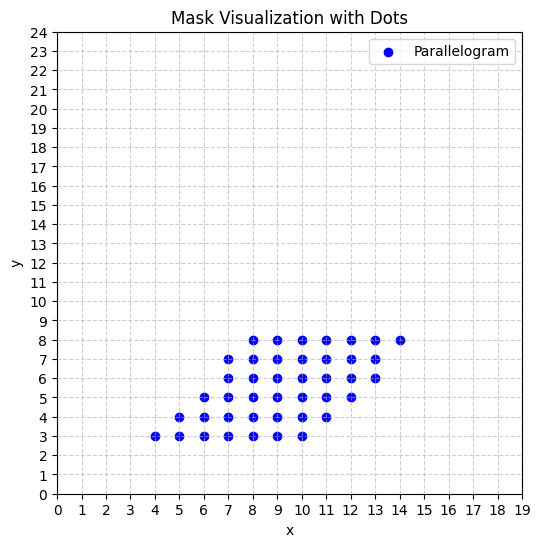

In [19]:
grid_height, grid_width = (20, 25)
start_x = 3
start_y = 4
height = 6
width = 7
tilt = 0.7
m2D = mask2D(start_x, start_y, height, width, tilt, grid_height, grid_width)
plot_mask2D(m2D, (grid_height, grid_width))

In [67]:
def animate_parallelepiped(mask, array_shape):
    # Extract coordinates where the mask is True
    print(mask.shape)
    y, x = np.where(mask[0])

    # Plot
    fig = plt.figure(figsize=(6, 6))
    ax = plt.gca()
    scat = ax.scatter(x, y, color='blue', marker='o', label='Parallelogram')
    # plt.gca().invert_yaxis()  # Match array indexing
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xticks(np.arange(0, array_shape[1]))
    ax.set_yticks(np.arange(0, array_shape[2]))
    ax.set_title("Parallelepiped Animation Along z-axis: frame 0")
    ax.set_xlabel("Columns (x)")
    ax.set_ylabel("Rows (y)")
    ax.legend()
    def update(frame):
        y, x = np.where(mask[frame])
        xy = np.stack([x, y]).T
        scat.set_offsets(xy)
        ax.set_title(f"Parallelepiped Animation Along z-axis, frame {frame}")
        return scat,
    
    ani = FuncAnimation(fig, update, frames=range(array_shape[0]), blit=True, interval=1000)
    return ani

In [68]:
def mask3D(start_x, start_y, start_z, height, width, depth, tilt_x, tilt_y, tilt_xy, grid_height, grid_width, grid_depth):
    # tilt_x is  height/ depth, x/z
    # tilt_y is width / depth, y/z
    # tilt_xy is width / height, y/x
    # height maps to x, axis 1
    # width maps to y, axis 2
    # depth maps to z, axis 0
    z = torch.arange(grid_depth).view(-1, 1, 1)  # Shape: (grid_depth, 1, 1)
    x = torch.arange(grid_height).view(1, -1, 1)  # Shape: (1, grid_height, 1)
    y = torch.arange(grid_width).view(1, 1, -1)  # Shape: (1, 1, grid_width)

    # Compute offsets
    x_offsets_per_z = torch.floor((z - start_z) * tilt_x).clamp(min=0) # (grid_depth, 1, 1)
    y_offsets_per_z = torch.floor((z - start_z) * tilt_y).clamp(min=0) # (grid_depth, 1, 1)
    y_offsets_per_x = (x - start_x) * tilt_xy # (1, grid_height, 1)

    # Compute start and end indices
    x_starts = (start_x + x_offsets_per_z).clamp(0, grid_height - 1) # (grid_depth, grid_height, 1)
    x_ends = (x_starts + height).clamp(0, grid_height) # (grid_depth, grid_height, 1)
    y_starts = (start_y + y_offsets_per_z + y_offsets_per_x).clamp(0, grid_width - 1) # (grid_depth, grid_height, grid_width)
    y_ends = (y_starts + width).clamp(0, grid_width) # (grid_depth, grid_height, grid_width)

    # Create the mask
    x_in_range = (x >= x_starts) & (x < x_ends)
    y_in_range = (y >= y_starts) & (y < y_ends)
    z_in_range = (z >= start_z) & (z < start_z + depth)
    mask = x_in_range & y_in_range & z_in_range
    return mask

In [69]:
#m3d = np.stack([m2D, m2D, m2D])
grid_depth, grid_height, grid_width = (10, 20, 25)
start_x = 1
start_y = 4
start_z = 1
height = 6
width = 7
depth = 6
tilt_x = 0.7
tilt_y = 1.3
tilt_xy = 2
m3D = mask3D(start_x, start_y, start_z, height, width, depth, tilt_x, tilt_y, tilt_xy, grid_height, grid_width, grid_depth)

In [70]:
# print(m3D)

torch.Size([10, 20, 25])


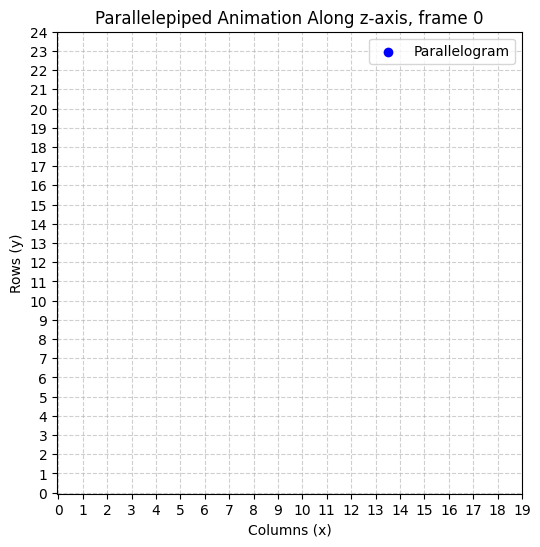

In [71]:
ani = animate_parallelepiped(m3D, [grid_depth, grid_height, grid_width])

In [72]:
HTML(ani.to_jshtml())